# Transformer based Neural Network for RUL Prediction

## Introduction

This notebook focuses on designing and implementing neural network models for predicting the Remaining Useful Life (RUL) of engines using the NASA CMAPSS dataset and a transformer based model. The dataset provides multivariate time-series data capturing engine operational and sensor measurements. By analyzing these sequences, we aim to estimate the RUL, which is critical for predictive maintenance and avoiding unexpected failures.

In this notebook we are going to NOT use the **engineered** features.

### Objectives
1. **Develop a Baseline Model:** (Done)
   - Implement a baseline neural network using **RNN** layers to leverage the sequential nature of the data.
   - Evaluate the baseline model's performance as a benchmark.

2. **Experiment with more complex models like GRU and Transformer-Based Models:**
   - Implement a more advanced architecture based on transformers for sequence modeling and feature extraction.
   - Compare its performance with the LSTM-based baseline model.

### Plan
1. **Prepare the Data:**
   - Use the preprocessed and scaled dataset created in previous notebooks.
   - Ensure the dataset supports both original features and optional engineered features for flexibility in experimentation.

2. **Baseline Model (LSTM):**
   - Use LSTM layers to capture temporal dependencies in the sequence data.
   - Evaluate the model's performance using Mean Squared Error (MSE) as the loss metric.

3. **Transformer-Based Model:**
   - Design a transformer architecture for sequence-to-sequence modeling.
   - Focus on capturing long-range dependencies and complex interactions among features.

4. **Model Comparison and Evaluation:**
   - Compare the models on key metrics such as Mean Absolute Error (MAE) and MSE.
   - Analyze the advantages and trade-offs of each approach.

### Why Use LSTMs and Transformers?
- **LSTMs:** 
  - Effective at capturing temporal dependencies and patterns in sequential data.
  - Provide a strong benchmark for sequence modeling tasks.
- **Transformers:**
  - Offer enhanced capability to model long-range dependencies compared to LSTMs.
  - Utilize attention mechanisms to focus on the most relevant parts of the sequence.

### Expected Outcome
By the end of this notebook, we aim to:
- Establish a strong baseline model for RUL prediction.
- Explore the potential of transformer-based models for handling sequence data.
- Gain insights into the strengths and limitations of these architectures for predictive maintenance tasks.

Let's begin by loading the prepared dataset and setting up the baseline model.


# Preparing our existing CMAPSSDataset for a transformer based network
Our sequence based CMAPSSDataset is already in good shape to serve as a data pipeline for the transformer net architecture. But we need to add one thing:

1. Creating an attention mask to ignore padded timesteps

**Another** task is:

1. Clarify the question how you pool the final sequence embedding (mean pooling, [CLS] token, etc.)


## Pooling the Final Sequence Embedding in Transformer Models

Pooling the **final sequence embeddings** is a critical step in Transformer-based models for time-series tasks like RUL prediction. Let’s break it down and explore the options:

---

### 1. **Why Do You Need Pooling?**

The Transformer outputs embeddings for **each timestep** (sequence position). For example:
- Input: Shape $(\text{batch size}, \text{seq len}, \text{feature dim})$
- Transformer Output: Shape $(\text{batch size}, \text{seq len}, \text{d\_model})$

Each row in this output corresponds to the representation of a specific timestep, enriched by attention over the entire sequence. However:
- For **RUL prediction**, you need a **single output vector** per sequence because RUL is a scalar (one value per sequence).
- To get this single vector, you must **pool** the sequence embeddings into one representation.

---

### 2. **Common Pooling Strategies**

#### 2.1. **Mean Pooling (Global Average Pooling)**

- Take the average of all timestep embeddings across the sequence:
  $$
  \text{pooled\_vector} = \frac{1}{\text{seq len}} \sum_{t=1}^{\text{seq len}} \text{embeddings}[t]
  $$
- This results in a single vector of shape $(\text{batch size}, \text{d\_model})$.

**Advantages**:
- Simple and computationally efficient.
- Works well when every timestep contributes equally to the sequence’s meaning.

**Disadvantages**:
- Assumes all timesteps are equally important, which may not hold if some timesteps contain more critical information (e.g., degradation trends at later cycles).

---

#### 2.2. **Max Pooling**

- Take the maximum value across timesteps for each embedding dimension:
  $$
  \text{pooled\_vector}[i] = \max_{t=1}^{\text{seq len}} \text{embeddings}[t][i]
  $$
- Shape: $(\text{batch size}, \text{d\_model})$.

**Advantages**:
- Focuses on the most “prominent” features across the sequence, which may highlight key degradation signals.

**Disadvantages**:
- Discards subtler variations across timesteps, which might be useful for RUL prediction.

---

#### 2.3. **Attention-Based Pooling**

Instead of fixed pooling (mean or max), you can use an **attention mechanism** to compute a weighted sum of embeddings:
- Learn a weight for each timestep based on its importance.
- Formula:
  $$
  \text{pooled\_vector} = \sum_{t=1}^{\text{seq len}} \alpha_t \cdot \text{embeddings}[t]
  $$
  where $\alpha_t$ are attention weights:
  $$
  \alpha_t = \text{softmax}(W \cdot \text{embeddings}[t])
  $$
- $W$ is a learnable parameter (linear layer).

**Advantages**:
- Dynamically learns which timesteps are most important.
- Especially useful for RUL prediction, where later timesteps may carry more degradation information.

**Disadvantages**:
- Adds extra parameters and computation.

---

#### 2.4. **[CLS] Token**

Inspired by Transformers in NLP (e.g., BERT), you can prepend a **special token** (e.g., `[CLS]`) to your input sequence. This token:
- Has its own learnable embedding.
- After passing through the Transformer, the embedding of the `[CLS]` token represents the entire sequence.

**Advantages**:
- Simple to implement.
- The model learns to focus the `[CLS]` embedding on the overall sequence meaning.

**Disadvantages**:
- The `[CLS]` token may not always effectively summarize the sequence, especially for smaller datasets or unoptimized models.

---

#### 2.5. **Last Timestep**

For some sequence tasks, only the final timestep is considered (similar to an RNN’s default behavior). Here, you directly take the last timestep embedding:
- 
$$
\text{pooled\_vector} = \text{embeddings}[-1]
$$
- Shape: $(\text{batch size}, \text{d\_model})$.

**Advantages**:
- Simple and intuitive for time-series tasks like RUL, where later timesteps are often more indicative of failure.
- Computationally cheap.

**Disadvantages**:
- Ignores information from earlier timesteps, which may still contain valuable signals (e.g., long-term trends).

---

### 3. **Which Pooling Strategy to Use?**

#### Recommendations for the NASA Turbofan Dataset:

1. **Start with Mean Pooling**:  
   - It’s simple, effective, and works well as a baseline.

2. **Explore Attention-Based Pooling**:  
   - Particularly useful for RUL prediction since later timesteps often dominate the degradation signal.

3. **Consider Last Timestep**:  
   - If your sequences are long, or the model focuses too much on early cycles, this can prioritize the most recent data.

4. **[CLS] Token**:  
   - Works well for full-sequence modeling. If you’re using variable-length sequences or Transformers with a fixed input length, `[CLS]` pooling can be a robust alternative.

---

### 4. **Code Examples**

#### Mean Pooling
```python
class TransformerRULModel(nn.Module):
    def forward(self, x, mask=None):
        # x: (batch_size, seq_len, d_model)
        x = self.transformer_encoder(x, src_key_padding_mask=mask)
        # Mean pooling over sequence dimension
        x = x.mean(dim=1)  # Shape: (batch_size, d_model)
        output = self.regressor(x)
        return output
```

---

#### Attention-Based Pooling
```python
class TransformerRULModel(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.Tanh(),
            nn.Linear(d_model, 1)  # Scalar score for each timestep
        )
        self.regressor = nn.Linear(d_model, 1)

    def forward(self, x, mask=None):
        # x: (batch_size, seq_len, d_model)
        x = self.transformer_encoder(x, src_key_padding_mask=mask)

        # Attention weights
        attn_scores = self.attention(x)  # Shape: (batch_size, seq_len, 1)
        attn_weights = torch.softmax(attn_scores, dim=1)  # Shape: (batch_size, seq_len, 1)

        # Weighted sum
        context_vector = (x * attn_weights).sum(dim=1)  # Shape: (batch_size, d_model)
        output = self.regressor(context_vector)  # Shape: (batch_size, 1)
        return output
```

---

#### [CLS] Token
```python
class TransformerRULModel(nn.Module):
    def forward(self, x, mask=None):
        # Add [CLS] token to the input
        cls_token = self.cls_embedding.expand(x.size(0), 1, -1)  # Shape: (batch_size, 1, d_model)
        x = torch.cat([cls_token, x], dim=1)  # Shape: (batch_size, seq_len+1, d_model)

        x = self.transformer_encoder(x, src_key_padding_mask=mask)

        # Use the first embedding (CLS token)
        cls_embedding = x[:, 0, :]  # Shape: (batch_size, d_model)
        output = self.regressor(cls_embedding)  # Shape: (batch_size, 1)
        return output
```

---

### 5. **Comparison of Strategies**

| **Pooling Method**   | **Advantages**                          | **Disadvantages**                     | **Use Case**                                 |
|-----------------------|------------------------------------------|----------------------------------------|----------------------------------------------|
| **Mean Pooling**      | Simple, efficient                       | Assumes all timesteps are equally important | Baseline for most tasks                       |
| **Max Pooling**       | Focuses on prominent features           | Ignores subtler signals                | Detecting sharp degradation patterns         |
| **Attention Pooling** | Learns importance dynamically           | Computationally more expensive         | Tasks with unequal timestep importance       |
| **[CLS] Token**       | Learns an explicit sequence summary     | Requires training to focus on `[CLS]` | General-purpose; good for variable-length    |
| **Last Timestep**     | Prioritizes most recent timesteps       | Ignores earlier sequence information   | Strong trend toward failure in final cycles  |

---

**Final Advice**: Start simple (mean pooling) and evaluate. If mean pooling doesn’t capture RUL trends effectively, experiment with attention-based pooling or [CLS] tokens.


Test the datasets and data loaders (those are **not** used for training):

In [1]:
import pandas as pd

from codebase.v5.data import prepare_sequence_dataloader, test_sequence_dataset

# Set up paths and features
data_dir = "data/CMAPSSData"
data_index = 1  # Choose FD001, FD002, etc.

compute_engineered_features = True
sequence_length = 60
batch_size = 256
overlap = 10

train_data = pd.read_csv("./data/CMAPSSData/train_FD001.txt", sep=r'\s+', header=None)
train_data.columns = ['engine_id', 'cycle'] + [f'os_{i+1}' for i in range(3)] + [f'sensor_{i}' for i in range(1, 22)]

feature_cols = [f'os_{i+1}' for i in range(3)] + [f'sensor_{i}' for i in range(1, 22)]

constant_cols = train_data[feature_cols].nunique()
constant_cols = constant_cols[constant_cols == 1]

feature_cols = [col for col in feature_cols if col not in constant_cols.index.tolist()]

# Prepare DataLoader
train_loader, tabular_dataset_train, sequence_train = prepare_sequence_dataloader(
    data_dir=data_dir, data_index=data_index, feature_cols=feature_cols, 
    batch_size=batch_size, mode="train", sequence_length=sequence_length, overlap=overlap,
    compute_engineered_features=compute_engineered_features)

print("Testing the Sequence Dataset (train):")

# Test the sequence dataset
test_sequence_dataset(train_loader, mode="train")

test_loader, tabular_dataset_test, sequence_test = prepare_sequence_dataloader(
    data_dir=data_dir, data_index=data_index, feature_cols=feature_cols, 
    batch_size=batch_size, mode="test", sequence_length=sequence_length, overlap=overlap,
    compute_engineered_features=compute_engineered_features, 
    scaler=tabular_dataset_train.scaler
)

print("\nTesting the Sequence Dataset (test):")
# Test the sequence dataset
test_sequence_dataset(test_loader, mode="test")

Testing the Sequence Dataset (train):
Batch 1
Sequences Shape: torch.Size([256, 60, 38])
Targets Shape: torch.Size([256])
Masks Shape: torch.Size([256, 60])
Engine Ids Shape: 256
Cycles Shape: torch.Size([256, 60])

Sample Sequence (First in Batch):
tensor([[-0.8639, -0.6919, -0.6328,  ...,  1.1114, -1.1580,  0.3762],
        [-1.9603, -0.3505, -1.1723,  ...,  0.9976, -1.2604, -0.4221],
        [ 0.4609,  0.3323, -0.4130,  ...,  0.8967, -1.7476,  0.1414],
        ...,
        [ 0.1868,  0.3323, -1.0324,  ...,  0.6529,  0.7298, -1.0748],
        [ 0.6893,  0.6737, -0.1732,  ...,  0.7715,  0.3295,  0.8739],
        [ 0.7807,  0.6737, -0.9125,  ...,  0.6396, -0.4595,  0.4924]])
Corresponding Target (First in Batch):
128.0
Engine ID (First in batch): 1
Cycles (First in batch): tensor([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
        23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
        41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 

## Prepare a grouped k-fold approach
See explanations in previous notebook.

In [1]:
# Watch for changes
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import torch

from codebase.v5.data import prepare_kfold_cross_validation_loaders, prepare_sequence_dataloader, test_sequence_dataset
from codebase.v5.dataset import CMAPSSDataset

# Save the model state dictionary
save_path = "saved_weights/"
feature_cols_path = os.path.join(save_path, "feature_cols.pth")
config_path = os.path.join(save_path, "config.pth")
model_path = os.path.join(save_path, "model.pth")
scaler_path = os.path.join(save_path, "scaler.pth")

# Set up paths and features
data_dir = "data/CMAPSSData"
data_index = 1  # Choose FD001, FD002, etc.

compute_engineered_features = True
sequence_length = 60
batch_size = 256
overlap = 10

train_data = pd.read_csv("./data/CMAPSSData/train_FD001.txt", sep=r'\s+', header=None)
train_data.columns = ['engine_id', 'cycle'] + [f'os_{i+1}' for i in range(3)] + [f'sensor_{i}' for i in range(1, 22)]

feature_cols = [f'os_{i+1}' for i in range(3)] + [f'sensor_{i}' for i in range(1, 22)]

constant_cols = train_data[feature_cols].nunique()
constant_cols = constant_cols[constant_cols == 1]

feature_cols = [col for col in feature_cols if col not in constant_cols.index.tolist()]

torch.save(feature_cols, feature_cols_path)
print(f"Feature columns saved to {feature_cols_path}")

# Initialize the dataset
tabular_dataset = CMAPSSDataset(
    data_dir=data_dir,
    data_index=data_index,
    feature_cols=feature_cols,
    mode="train",
    compute_engineered_features=compute_engineered_features,
    features_to_engineer=["sensor_12", "sensor_7", "sensor_21", "sensor_20", "sensor_11", "sensor_4", "sensor_15"]
)

tabular_dataset_test = CMAPSSDataset(
    data_dir=data_dir,
    data_index=data_index,
    feature_cols=feature_cols,
    mode="test",
    compute_engineered_features=compute_engineered_features,
    features_to_engineer=["sensor_12", "sensor_7", "sensor_21", "sensor_20", "sensor_11", "sensor_4", "sensor_15"],
    scaler=tabular_dataset.scaler
)

# save the scaler for the test dataset
torch.save(tabular_dataset.scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")

# Perform Group k-Fold Cross-Validation
n_splits = 5

# 2. Perform Group k-Fold Cross-Validation
fold_loaders = prepare_kfold_cross_validation_loaders(
    original_dataset=tabular_dataset,
    sequence_length=sequence_length,
    overlap=overlap,
    n_splits=n_splits,
    batch_size=batch_size
)

test_loader, sequence_test = prepare_sequence_dataloader(    
    tabular_dataset=tabular_dataset_test, 
    batch_size=batch_size, mode="test", 
    sequence_length=sequence_length, overlap=overlap
)

# Access the DataLoaders for each fold
for fold, (train_loader, val_loader) in enumerate(fold_loaders):
    print(f"Fold {fold + 1}")
    
    # Training DataLoader
    print(f"  Number of training sequences: {len(train_loader.dataset)}")
    
    first_train_item = next(iter(train_loader))
    train_features, train_targets, train_masks, train_engine_ids, cycles = first_train_item
    
    print(f"  Training Features Shape: {train_features.shape}")
    print(f"  Training Targets Shape: {train_targets.shape}")
    print(f"  Training Masks Shape: {train_masks.shape}")
    print(f"  First Training Item (Features):\n{train_features[0]}")
    print(f"  First Training Item (Target): {train_targets[0]}")
    print(f"  Engine ID (First in batch): {train_engine_ids[0]}")
    print(f"  Cycles (For first sequence in batch): {cycles[0]}")
    
    # Validation DataLoader
    print(f"  Number of validation sequences: {len(val_loader.dataset)}")

    first_val_item = next(iter(val_loader))
    val_features, val_targets, val_masks, train_engine_ids, cycles = first_val_item
    
    print(f"  Validation Features Shape: {val_features.shape}")
    print(f"  Validation Targets Shape: {val_targets.shape}")
    print(f"  Validation Masks Shape: {val_masks.shape}")
    print(f"  First Validation Item (Features):\n{val_features[0]}")
    print(f"  First Validation Item (Target): {val_targets[0]}")
    print(f"  Engine ID (First in batch): {train_engine_ids[0]}")
    print(f"  Cycles (For first sequence in batch): {cycles[0]}")

    break  # Only display the first fold for demonstration

print("\nTesting the Sequence Dataset (test):")

# Test the sequence dataset
test_sequence_dataset(test_loader, mode="test")

Feature columns saved to saved_weights/feature_cols.pth
Scaler saved to saved_weights/scaler.pth
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Fold 1
  Number of training sequences: 363
  Training Features Shape: torch.Size([256, 60, 38])
  Training Targets Shape: torch.Size([256])
  Training Masks Shape: torch.Size([256, 60])
  First Training Item (Features):
tensor([[-0.8639, -0.6919, -0.6328,  ...,  1.1114, -1.1580,  0.3762],
        [-1.9603, -0.3505, -1.1723,  ...,  0.9976, -1.2604, -0.4221],
        [ 0.4609,  0.3323, -0.4130,  ...,  0.8967, -1.7476,  0.1414],
        ...,
        [ 0.1868,  0.3323, -1.0324,  ...,  0.6529,  0.7298, -1.0748],
        [ 0.6893,  0.6737, -0.1732,  ...,  0.7715,  0.3295,  0.8739],
        [ 0.7807,  0.6737, -0.9125,  ...,  0.6396, -0.4595,  0.4924]])
  First Training Item (Target): 128.0
  Engine ID (First in batch): 1
  Cycles (For first sequence in batch): tensor([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
        23, 24

## Validate the grouped k-fold loaders

In [5]:
import torch

def validate_kfold_loaders(original_dataset, fold_loaders):
    """
    Validates the integrity of k-fold DataLoaders against the original dataset.
    Also checks for NaN in features, targets, and cycles for both train and val loaders.

    Args:
        original_dataset (CMAPSSDataset): The original dataset instance.
        fold_loaders (list): List of (train_loader, val_loader) tuples for k-fold cross-validation.

    Returns:
        bool: True if all validations pass, otherwise raises an AssertionError or ValueError.
    """
    original_data = original_dataset.data
    used_indices = set()  # Track all rows covered across folds

    for fold, (train_loader, val_loader) in enumerate(fold_loaders):
        print(f"Validating Folds: {fold + 1}")
        
        # Get engine IDs for train and validation sets
        train_engines = set(train_loader.dataset.dataset.data['engine_id'])
        val_engines = set(val_loader.dataset.dataset.data['engine_id'])
        
        # Check group exclusivity
        assert train_engines.isdisjoint(val_engines), \
            f"Fold {fold + 1}: Train and validation sets share engine IDs: {train_engines & val_engines}"

        # ========== Validate Training Data ========== #
        for batch_idx, (features, targets, _, engine_ids, cycles) in enumerate(train_loader):
            # features shape: (batch_size, seq_len, num_features)
            # targets shape:  (batch_size,)
            # engine_ids shape: (batch_size,)
            # cycles shape:   (batch_size, seq_len)

            batch_size = features.size(0)
            for idx in range(batch_size):
                seq = features[idx]          # shape: (seq_len, num_features)
                target = targets[idx]        # scalar RUL value
                engine_id = engine_ids[idx]  # scalar engine ID
                seq_cycles = cycles[idx]     # shape: (seq_len,)

                # ---------- NaN checks ----------
                if torch.isnan(seq).any():
                    raise ValueError(
                        f"[Train] NaN found in features for engine {engine_id.item()}, "
                        f"batch {batch_idx}, sample {idx}"
                    )
                if torch.isnan(target):
                    raise ValueError(
                        f"[Train] NaN found in target for engine {engine_id.item()}, "
                        f"batch {batch_idx}, sample {idx}"
                    )
                # Convert cycles to float for NaN check (since cycles are usually int)
                if torch.isnan(seq_cycles.float()).any():
                    raise ValueError(
                        f"[Train] NaN found in cycles for engine {engine_id.item()}, "
                        f"batch {batch_idx}, sample {idx}"
                    )
                # ---------------------------------

                # Identify real (non-padded) timesteps (padded cycles = 0)
                real_timesteps = (seq_cycles != 0).sum().item()

                # Skip if everything is padded (unlikely in normal usage)
                if real_timesteps == 0:
                    continue

                # For each real timestep t in this sequence:
                for t in range(real_timesteps):
                    cycle_val = float(seq_cycles[t].item())
                    original_row = original_data[
                        (original_data['engine_id'] == float(engine_id)) & 
                        (original_data['cycle'] == cycle_val)
                    ]
                    assert not original_row.empty, (
                        f"Missing data for engine {engine_id}, cycle {cycle_val} in training set"
                    )

                    # Check feature alignment
                    original_features = original_row.iloc[0, 2:-1].values  # columns 2..-1 are features
                    assert torch.allclose(
                        seq[t], torch.tensor(original_features, dtype=torch.float32), atol=1e-6
                    ), f"Mismatch in features for engine {engine_id}, cycle {cycle_val}"

                # Verify RUL target using the last real cycle
                last_cycle = float(seq_cycles[real_timesteps - 1].item())
                expected_rul = original_data[
                    (original_data['engine_id'] == float(engine_id)) &
                    (original_data['cycle'] == last_cycle)
                ]['RUL'].iloc[0]

                assert torch.isclose(
                    target, torch.tensor(expected_rul, dtype=torch.float32), atol=1e-6
                ), f"Mismatch in RUL for engine {engine_id}, last cycle {last_cycle}"

        # ========== Validate Validation Data (same logic) ========== #
        for batch_idx, (features, targets, _, engine_ids, cycles) in enumerate(val_loader):
            batch_size = features.size(0)
            for idx in range(batch_size):
                seq = features[idx]
                target = targets[idx]
                engine_id = engine_ids[idx]
                seq_cycles = cycles[idx]

                # ---------- NaN checks ----------
                if torch.isnan(seq).any():
                    raise ValueError(
                        f"[Val] NaN found in features for engine {engine_id.item()}, "
                        f"batch {batch_idx}, sample {idx}"
                    )
                if torch.isnan(target):
                    raise ValueError(
                        f"[Val] NaN found in target for engine {engine_id.item()}, "
                        f"batch {batch_idx}, sample {idx}"
                    )
                if torch.isnan(seq_cycles.float()).any():
                    raise ValueError(
                        f"[Val] NaN found in cycles for engine {engine_id.item()}, "
                        f"batch {batch_idx}, sample {idx}"
                    )
                # ---------------------------------

                real_timesteps = (seq_cycles != 0).sum().item()
                if real_timesteps == 0:
                    continue

                for t in range(real_timesteps):
                    cycle_val = float(seq_cycles[t].item())
                    original_row = original_data[
                        (original_data['engine_id'] == float(engine_id)) & 
                        (original_data['cycle'] == cycle_val)
                    ]
                    assert not original_row.empty, (
                        f"Missing data for engine {engine_id}, cycle {cycle_val} in validation set"
                    )

                    original_features = original_row.iloc[0, 2:-1].values
                    assert torch.allclose(
                        seq[t], torch.tensor(original_features, dtype=torch.float32), atol=1e-6
                    ), f"Mismatch in features for engine {engine_id}, cycle {cycle_val}"

                last_cycle = float(seq_cycles[real_timesteps - 1].item())
                expected_rul = original_data[
                    (original_data['engine_id'] == float(engine_id)) &
                    (original_data['cycle'] == last_cycle)
                ]['RUL'].iloc[0]
                assert torch.isclose(
                    target, torch.tensor(expected_rul, dtype=torch.float32), atol=1e-6
                ), f"Mismatch in RUL for engine {engine_id}, last cycle {last_cycle}"

        # Track covered indices
        train_indices = train_loader.dataset.dataset.data.index
        val_indices = val_loader.dataset.dataset.data.index
        used_indices.update(train_indices)
        used_indices.update(val_indices)

    # Finally, ensure overall coverage if that's desired
    assert len(used_indices) == len(original_data), \
        "Not all rows in the original dataset are covered by the k-fold loaders"

    print("All validations passed!")
    return True

# Usage
validate_kfold_loaders(tabular_dataset, fold_loaders)

Validating Folds: 1
Validating Folds: 2
Validating Folds: 3
Validating Folds: 4
Validating Folds: 5
All validations passed!


True

## Inspect characteristics of each fold (to ensure they are homogenic)

Inspecting Fold 1
  Training RUL Statistics:
count    363.000000
mean      65.793388
std       63.607010
min        0.000000
25%        0.000000
50%       52.000000
75%      112.500000
max      277.000000
Name: RUL, dtype: float64
  Validation RUL Statistics:
count     91.000000
mean      66.197800
std       66.344597
min        0.000000
25%        0.000000
50%       51.000000
75%      109.000000
max      298.000000
Name: RUL, dtype: float64


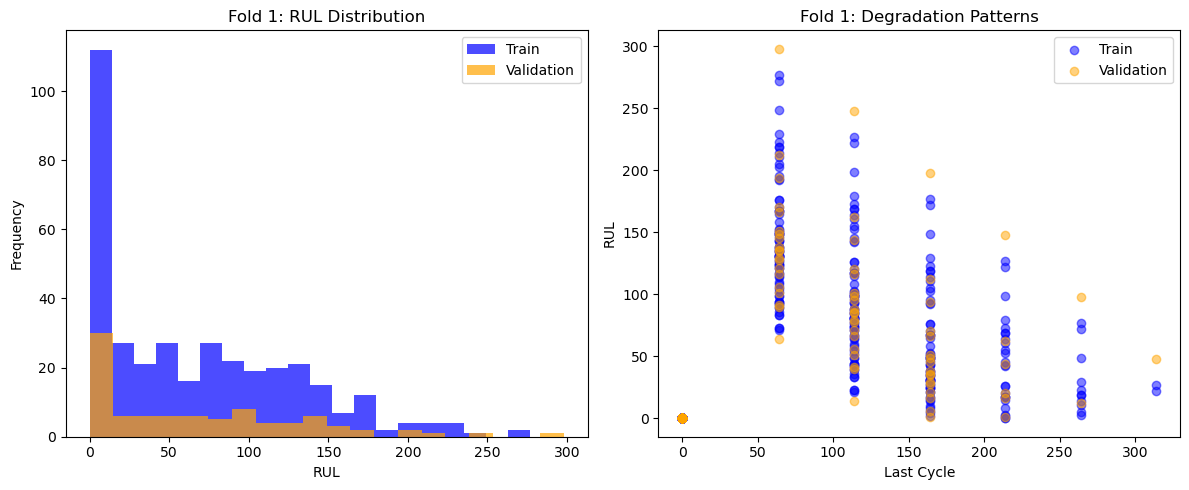

Inspecting Fold 2
  Training RUL Statistics:
count    363.000000
mean      65.831955
std       64.007553
min        0.000000
25%        0.000000
50%       51.000000
75%      111.500000
max      298.000000
Name: RUL, dtype: float64
  Validation RUL Statistics:
count     91.000000
mean      66.043953
std       64.777550
min        0.000000
25%        0.000000
50%       52.000000
75%      110.000000
max      277.000000
Name: RUL, dtype: float64


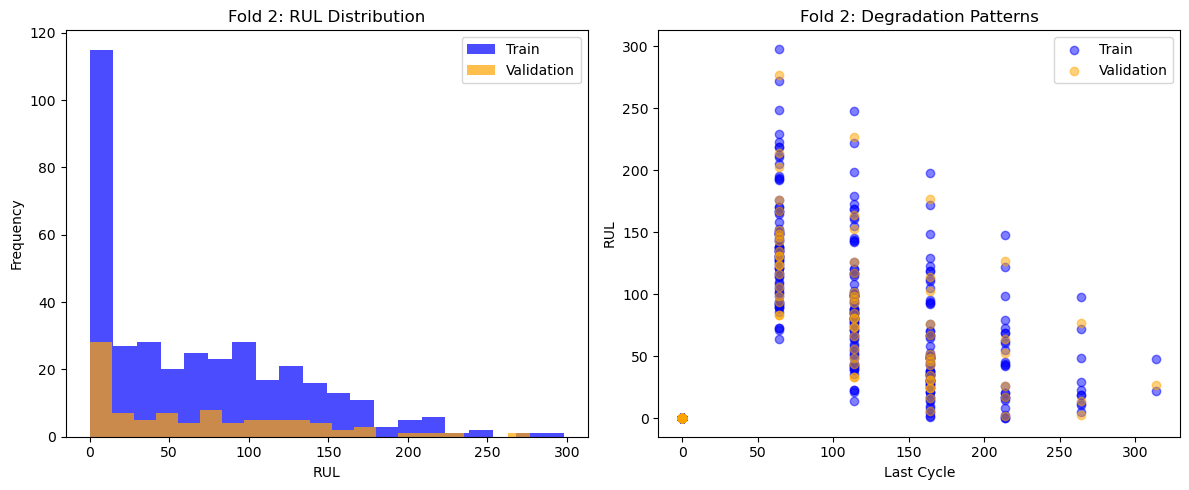

Inspecting Fold 3
  Training RUL Statistics:
count    364.000000
mean      65.714287
std       64.106041
min        0.000000
25%        0.000000
50%       51.000000
75%      111.250000
max      298.000000
Name: RUL, dtype: float64
  Validation RUL Statistics:
count     90.000000
mean      66.522224
std       64.383896
min        0.000000
25%        0.000000
50%       54.000000
75%      113.250000
max      272.000000
Name: RUL, dtype: float64


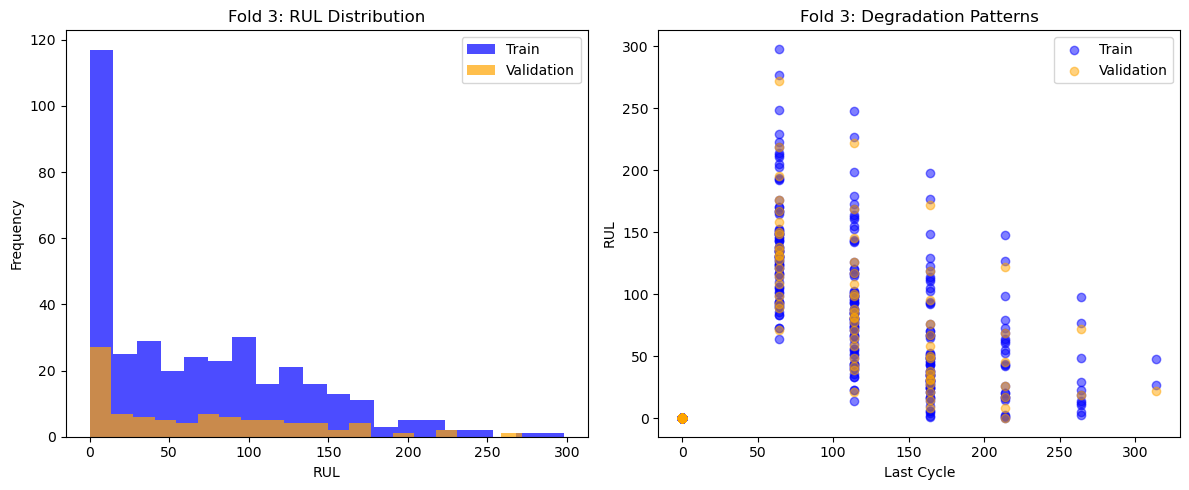

Inspecting Fold 4
  Training RUL Statistics:
count    362.000000
mean      66.201660
std       64.310417
min        0.000000
25%        0.000000
50%       51.000000
75%      113.500000
max      298.000000
Name: RUL, dtype: float64
  Validation RUL Statistics:
count     92.000000
mean      64.586960
std       63.551506
min        0.000000
25%        0.000000
50%       51.000000
75%      104.250000
max      249.000000
Name: RUL, dtype: float64


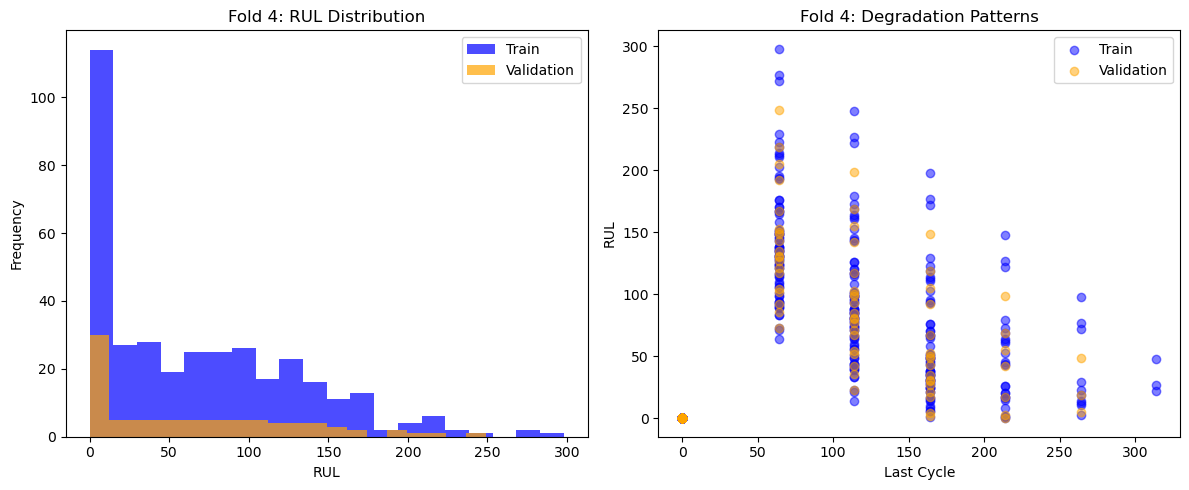

Inspecting Fold 5
  Training RUL Statistics:
count    364.000000
mean      65.832420
std       64.506142
min        0.000000
25%        0.000000
50%       51.000000
75%      109.000000
max      298.000000
Name: RUL, dtype: float64
  Validation RUL Statistics:
count     90.000000
mean      66.044441
std       62.736649
min        0.000000
25%        0.000000
50%       54.500000
75%      113.250000
max      229.000000
Name: RUL, dtype: float64


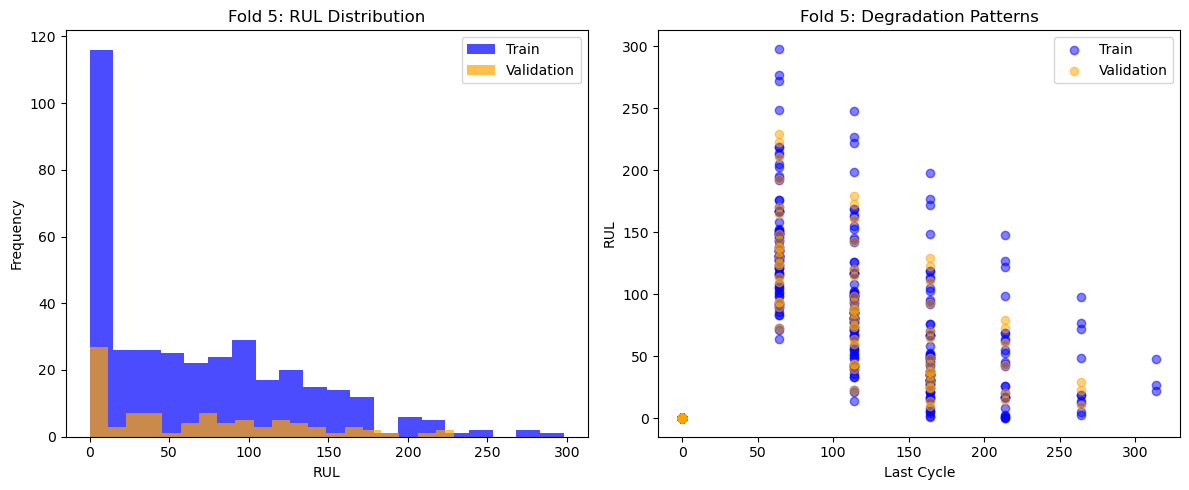

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

def inspect_fold_characteristics(fold_loaders):
    """
    Inspects and visualizes RUL distribution and degradation patterns for each fold.

    Args:
        fold_loaders (list): List of (train_loader, val_loader) tuples for k-fold cross-validation.
    """
    for fold, (train_loader, val_loader) in enumerate(fold_loaders):
        print(f"Inspecting Fold {fold + 1}")
        
        # Initialize lists to collect RUL and Cycle data
        train_ruls, train_last_cycles = [], []
        val_ruls, val_last_cycles = [], []
        
        # Collect RUL and last cycles for training
        for _, targets, _, _, cycles in train_loader:
            train_ruls.extend(targets.cpu().numpy())  # RUL values (batch_size,)
            last_cycles = cycles[:, -1].cpu().numpy()  # Last cycle in each sequence (batch_size,)
            train_last_cycles.extend(last_cycles.tolist())
        
        # Collect RUL and last cycles for validation
        for _, targets, _, _, cycles in val_loader:
            val_ruls.extend(targets.cpu().numpy())  # RUL values (batch_size,)
            last_cycles = cycles[:, -1].cpu().numpy()  # Last cycle in each sequence (batch_size,)
            val_last_cycles.extend(last_cycles.tolist())
        
        # Convert to Pandas DataFrames for analysis
        train_df = pd.DataFrame({"RUL": train_ruls, "Last Cycle": train_last_cycles})
        val_df = pd.DataFrame({"RUL": val_ruls, "Last Cycle": val_last_cycles})
        
        # Print summary statistics
        print("  Training RUL Statistics:")
        print(train_df["RUL"].describe())
        print("  Validation RUL Statistics:")
        print(val_df["RUL"].describe())
        
        # Plot RUL distributions
        plt.figure(figsize=(12, 5))
        
        # RUL Distribution
        plt.subplot(1, 2, 1)
        plt.hist(train_df["RUL"], bins=20, alpha=0.7, label="Train", color="blue")
        plt.hist(val_df["RUL"], bins=20, alpha=0.7, label="Validation", color="orange")
        plt.xlabel("RUL")
        plt.ylabel("Frequency")
        plt.title(f"Fold {fold + 1}: RUL Distribution")
        plt.legend()

        # Degradation Patterns
        plt.subplot(1, 2, 2)
        plt.scatter(train_df["Last Cycle"], train_df["RUL"], alpha=0.5, label="Train", color="blue")
        plt.scatter(val_df["Last Cycle"], val_df["RUL"], alpha=0.5, label="Validation", color="orange")
        plt.xlabel("Last Cycle")
        plt.ylabel("RUL")
        plt.title(f"Fold {fold + 1}: Degradation Patterns")
        plt.legend()
        
        plt.tight_layout()
        plt.show()

# Call the function to inspect fold characteristics
inspect_fold_characteristics(fold_loaders)

# K-Fold evaluation and development of model as preparation for a final training

In [12]:
# Watch for changes
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from codebase.v5.models import TransformerRULModel
from tqdm.notebook import tqdm  # Use tqdm for Jupyter-friendly progress bar

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model configuration
input_dim = len(tabular_dataset.feature_cols)  # Number of input features (contains engineered features)

def train_and_validate_kfold(fold_loaders, model_config, epochs=500, lr=0.001, weight_decay=1e-6, patience=10):
    """
    Train and validate the model using grouped k-fold cross-validation with early stopping.
    Summarizes metrics (e.g., RMSE, Avg MSE) across all folds.

    Args:
        fold_loaders (list): List of (train_loader, val_loader) tuples for k-fold cross-validation.
        model_config (dict): Configuration for the model (e.g., input_dim, hidden_dim, num_layers).
        epochs (int): Maximum number of epochs to train for each fold.
        lr (float): Learning rate for the optimizer.
        patience (int): Number of epochs with no improvement before stopping.

    Returns:
        dict: Summary of metrics across all folds.
    """
    # Track metrics for all folds
    fold_metrics = {
        "train_rmse": [],
        "val_rmse": [],
        "train_avg_mse": [],
        "val_avg_mse": [],
    }

    # Loop over each fold
    for fold, (train_loader, val_loader) in enumerate(fold_loaders):
        print(f"Current Validation Fold {fold + 1}")
        
        # Initialize model, loss function, and optimizer
        model = TransformerRULModel(**model_config)
        model = model.to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        
        # Early stopping variables
        best_val_loss = float('inf')
        epochs_no_improve = 0
        early_stop = False

        # Initialize progress bar for this fold
        total_batches = len(train_loader) * epochs
        with tqdm(total=total_batches, desc=f"Fold {fold + 1} Training", unit="batch") as pbar:
            for epoch in range(epochs):
                if early_stop:
                    print(f"Early stopping at epoch {epoch + 1}")
                    break
                
                model.train()
                train_loss = 0.0  # Track training loss
                num_train_sequences = len(train_loader.dataset)

                # Training loop
                for inputs, targets, masks, _, _ in train_loader:
                    optimizer.zero_grad()
                    inputs, targets, masks = inputs.to(device), targets.to(device), masks.to(device)
                    
                    # Forward pass
                    outputs = model(inputs, masks)
                    loss = criterion(outputs, targets)
                    
                    # Backward pass and optimization
                    loss.backward()
                    optimizer.step()
                    
                    # Accumulate loss
                    train_loss += loss.item() * inputs.size(0)
                    
                    # Update progress bar
                    pbar.update(1)
                
                # Compute training metrics
                avg_train_mse = train_loss / num_train_sequences
                train_rmse = avg_train_mse ** 0.5

                # Validation loop
                model.eval()
                val_loss = 0.0
                num_val_sequences = len(val_loader.dataset)
                with torch.no_grad():
                    for inputs, targets, masks, _, _ in val_loader:
                        inputs, targets, masks = inputs.to(device), targets.to(device), masks.to(device)
                        
                        # Forward pass
                        outputs = model(inputs, masks)
                        loss = criterion(outputs, targets)
                        
                        # Accumulate validation loss
                        val_loss += loss.item() * inputs.size(0)
                
                # Compute validation metrics
                avg_val_mse = val_loss / num_val_sequences
                val_rmse = avg_val_mse ** 0.5

                # Check for early stopping
                if avg_val_mse < best_val_loss:
                    best_val_loss = avg_val_mse
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                    print(f"No improvement for {epochs_no_improve} epoch(s).")

                if epochs_no_improve >= patience:
                    print("Early stopping triggered.")
                    early_stop = True

                # Print epoch metrics
                pbar.set_postfix({
                    "Epoch": f"{epoch + 1}/{epochs}",
                    "Train Loss": f"Avg MSE: {avg_train_mse:.4f}, RMSE: {train_rmse:.4f}",
                    "Val Loss:": f"Avg MSE: {avg_val_mse:.4f}, RMSE: {val_rmse:.4f}"
                })
                pbar.update(0)

        # Store fold metrics
        fold_metrics["train_rmse"].append(train_rmse)
        fold_metrics["val_rmse"].append(val_rmse)
        fold_metrics["train_avg_mse"].append(avg_train_mse)
        fold_metrics["val_avg_mse"].append(avg_val_mse)

    # Summarize metrics across all folds
    summary = {
        "mean_train_rmse": sum(fold_metrics["train_rmse"]) / len(fold_metrics["train_rmse"]),
        "mean_val_rmse": sum(fold_metrics["val_rmse"]) / len(fold_metrics["val_rmse"]),
        "mean_train_avg_mse": sum(fold_metrics["train_avg_mse"]) / len(fold_metrics["train_avg_mse"]),
        "mean_val_avg_mse": sum(fold_metrics["val_avg_mse"]) / len(fold_metrics["val_avg_mse"]),
    }

    print("\n--- k-Fold Cross-Validation Summary ---")
    for key, value in summary.items():
        print(f"{key}: {value:.4f}")

    return summary

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
# Define model configuration
# Define model configuration
model_config = {
    "input_dim": input_dim,
    "d_model": 96,
    "nhead": 4,
    "num_layers": 1,
    "dim_feedforward": 192,
    "dropout": 0.4333827218510093,
}

learning_rate = 0.003895180196123437
weight_decay = 6.638328586838593e-06

# Train using k-fold loaders
summary = train_and_validate_kfold(fold_loaders, model_config, epochs=50, lr=learning_rate, weight_decay=weight_decay, patience=10)

Validation Fold 1


Fold 1 Training:   0%|          | 0/1000 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).
No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 38
Validation Fold 2


Fold 2 Training:   0%|          | 0/1000 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).
No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 48
Validation Fold 3


Fold 3 Training:   0%|          | 0/1000 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).
No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 32
Validation Fold 4


Fold 4 Training:   0%|          | 0/1000 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).
No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 42
Validation Fold 5


Fold 5 Training:   0%|          | 0/1000 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).
No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 35

--- k-Fold Cross-Validation Summary ---
mean_train_rmse: 30.2889
mean_val_rmse: 34.8982
mean_train_avg_mse: 919.2871
mean_val_avg_mse: 1222.1316


As a result of our k-Fold Cross Validation we can see that our fold setup yields an **average validation RMSE** of 34.8982.

# K-Fold evaluation: Using Optuna for hyperparameter search
Let's use Optuna for an efficient hyperparameter search.

In [ ]:
import optuna

def objective(trial):
    """
    Objective function for Optuna hyperparameter optimization.
    Calls the existing train_and_validate_kfold function.
    """
    # Ensure transformer_d_model is divisible by transformer_nhead
    nhead = trial.suggest_int("nhead", 2, 8, step=2)
    d_model = trial.suggest_int(
        "d_model", nhead * 16, nhead * 32, step=nhead * 8
    )
    
    dim_feedworward = trial.suggest_int("dim_feedforward", 128, 512, step=64)
    num_layers = trial.suggest_int("num_layers", 1, 4)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)

    # Create the model configuration for the trial
    # input_dim, hidden_dim=256, num_heads=3, num_layers=1, dropout=0.3
    # Define model configuration
    model_config = {
        "input_dim": input_dim,
        "d_model": d_model,
        "nhead": nhead,
        "num_layers": num_layers,
        "dim_feedforward": dim_feedworward,
        "dropout": dropout,
    }

    # Call your existing train_and_validate_kfold function
    summary = train_and_validate_kfold(
        fold_loaders=fold_loaders,
        model_config=model_config,
        epochs=100,  # Fewer epochs for faster tuning
        lr=lr,
        weight_decay=weight_decay,
        patience=10  # Early stopping patience
    )

    # Return the mean validation RMSE as the objective value
    return summary["mean_val_rmse"]

# Optuna study configuration
study = optuna.create_study(direction="minimize")  # Minimize RMSE
study.optimize(objective, n_trials=50)  # Number of trials for hyperparameter tuning

# Print the best hyperparameters and validation RMSE
print("Best hyperparameters:", study.best_params)
print("Best validation RMSE:", study.best_value)

# Training without K-Fold

In [2]:
# Watch for changes
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm  # Use tqdm for Jupyter-friendly progress bar

from codebase.v5.models import TransformerRULModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = len(tabular_dataset.feature_cols)  # Number of input features (contains engineered features)

def train_and_validate_single_run(
    train_loader, val_loader,
    model_config,
    epochs=500,
    lr=0.001,
    weight_decay=1e-6,
    patience=10,
    model_path="saved_weights/model.pth",
    loss_type="mse",  # "mse" or "huber"
):
    """
    Train and validate the model using a *single* train/validation set (no k-fold).
    Summarizes metrics (e.g., RMSE, Avg Loss) for this single train/val split.

    Args:
        fold_loaders (list): List containing a single (train_loader, val_loader) tuple.
        model_config (dict): Configuration for the model (e.g., input_dim, d_model, num_layers).
        epochs (int): Maximum number of epochs to train.
        lr (float): Learning rate for the optimizer.
        weight_decay (float): Weight decay for regularization.
        patience (int): Number of epochs with no improvement before stopping.
        model_path (str): Where to save the best model weights.
        loss_type (str): "mse" or "huber". Determines which loss function is used.

    Returns:
        model (nn.Module): Trained model (best validation loss).
        summary (dict): Summary of metrics for the single train/val run.
    """

    # We'll use only the first tuple from fold_loaders
    
    print("Using standard train/validation approach instead of k-fold.")

    # ======================
    #  Set up model & loss
    # ======================
    model = TransformerRULModel(**model_config).to(device)

    # Choose the loss function based on loss_type
    if loss_type.lower() == "mse":
        criterion = nn.MSELoss()
    elif loss_type.lower() == "huber":
        criterion = nn.HuberLoss(delta=1.0)
    else:
        raise ValueError(f"Invalid loss_type: {loss_type}. Choose 'mse' or 'huber'.")

    # AdamW optimizer
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Track metrics for this single run
    fold_metrics = {
        "train_loss": [],
        "val_loss": [],
        "train_rmse": [],
        "val_rmse": [],
    }

    # Early stopping variables
    best_val_loss = float("inf")
    best_epoch = 0
    epochs_no_improve = 0
    early_stop = False

    # ======================
    #  Training Loop
    # ======================
    total_batches = len(train_loader) * epochs
    with tqdm(total=total_batches, desc="Training", unit="batch") as pbar:
        for epoch in range(epochs):
            if early_stop:
                print(f"Early stopping at epoch {epoch + 1}")
                break

            # ---------------------------
            # 1. Training
            # ---------------------------
            model.train()
            train_loss_accum = 0.0
            train_predictions = []
            train_targets_all = []

            for inputs, targets, masks, _, _ in train_loader:
                optimizer.zero_grad()

                inputs = inputs.to(device)
                targets = targets.to(device)
                masks = masks.to(device)

                outputs = model(inputs, masks)  # (batch_size,)

                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                # Accumulate for final averaging
                batch_size = inputs.size(0)
                train_loss_accum += loss.item() * batch_size

                # For RMSE calculation, store predictions & targets
                train_predictions.append(outputs.detach().cpu())
                train_targets_all.append(targets.detach().cpu())

                pbar.update(1)

            # Compute average training loss
            num_train_samples = len(train_loader.dataset)
            avg_train_loss = train_loss_accum / num_train_samples

            # Compute training RMSE
            train_predictions = torch.cat(train_predictions, dim=0)
            train_targets_all = torch.cat(train_targets_all, dim=0)
            train_rmse = torch.sqrt(torch.mean((train_predictions - train_targets_all) ** 2)).item()

            # ---------------------------
            # 2. Validation
            # ---------------------------
            model.eval()
            val_loss_accum = 0.0
            val_predictions = []
            val_targets_all = []

            with torch.no_grad():
                for inputs, targets, masks, _, _ in val_loader:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    masks = masks.to(device)

                    outputs = model(inputs, masks)
                    loss = criterion(outputs, targets)

                    batch_size = inputs.size(0)
                    val_loss_accum += loss.item() * batch_size

                    val_predictions.append(outputs.cpu())
                    val_targets_all.append(targets.cpu())

            num_val_samples = len(val_loader.dataset)
            avg_val_loss = val_loss_accum / num_val_samples

            val_predictions = torch.cat(val_predictions, dim=0)
            val_targets_all = torch.cat(val_targets_all, dim=0)
            val_rmse = torch.sqrt(torch.mean((val_predictions - val_targets_all) ** 2)).item()

            # ---------------------------
            # 3. Early Stopping Logic
            # ---------------------------
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_val_rmse = val_rmse

                epochs_no_improve = 0
                best_epoch = epoch + 1
                torch.save(model.state_dict(), model_path)
            else:
                epochs_no_improve += 1
                print(f"No improvement for {epochs_no_improve} epoch(s).")

            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                early_stop = True

            # Record stats
            fold_metrics["train_loss"].append(avg_train_loss)
            fold_metrics["val_loss"].append(avg_val_loss)
            fold_metrics["train_rmse"].append(train_rmse)
            fold_metrics["val_rmse"].append(val_rmse)

            # ---------------------------
            # 4. TQDM Logging
            # ---------------------------
            pbar.set_postfix({
                "Epoch": f"{epoch + 1}/{epochs}",
                "Train Loss": f"{avg_train_loss:.4f}",
                "Train RMSE": f"{train_rmse:.4f}",
                "Val Loss": f"{avg_val_loss:.4f}",
                "Val RMSE": f"{val_rmse:.4f}"
            })
            pbar.update(0)

    # ======================
    #  Final Summary
    # ======================
    # Load best model
    model.load_state_dict(torch.load(model_path))

    # Summaries
    summary = {
        "best_epoch": best_epoch,
        "best_val_loss": best_val_loss,
        "best_val_rmse": best_val_rmse,
        "final_train_loss": fold_metrics["train_loss"][-1] if fold_metrics["train_loss"] else None,
        "final_val_loss": fold_metrics["val_loss"][-1] if fold_metrics["val_loss"] else None,
        "final_train_rmse": fold_metrics["train_rmse"][-1] if fold_metrics["train_rmse"] else None,
        "final_val_rmse": fold_metrics["val_rmse"][-1] if fold_metrics["val_rmse"] else None,
    }

    print("\n--- Train/Validation Summary ---")
    for key, value in summary.items():
        print(f"{key}: {value}")

    print(f"\nTraining complete. Best model loaded (epoch {best_epoch}).")

    return model, summary

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Best hyperparameters: 
#   {'nhead': 4, 'd_model': 96, 'dim_feedforward': 192, 'num_layers': 1, 'dropout': 0.4333827218510093, 
#       'lr': 0.003895180196123437, 'weight_decay': 6.638328586838593e-06}
# Best validation RMSE: 34.41191377372541

# Define model configuration
model_config = {
    "input_dim": input_dim,
    "d_model": 96,
    "nhead": 4,
    "num_layers": 1,
    "dim_feedforward": 192,
    "dropout": 0.4333827218510093,
}

learning_rate = 0.003895180196123437
weight_decay = 6.638328586838593e-06

train_loader, val_loader = fold_loaders[1]

# Train using k-fold loaders
model, summary = train_and_validate_single_run(
        train_loader=train_loader, val_loader=val_loader,
        model_config=model_config,
        epochs=100, 
        lr=learning_rate,
        weight_decay=weight_decay,
        patience=10,
        loss_type="mse"
    )

Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/200 [00:00<?, ?batch/s]

/home/oliver/anaconda3/envs/pytorch_env/lib/python3.10/site-packages/torch/nn/modules/transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647327489/work/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).
No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 38

--- Train/Validation Summary ---
best_epoch: 27
best_val_loss: 738.785400390625
best_val_rmse: 27.180606842041016
final_train_loss: 774.98695798091
final_val_loss: 905.6620483398438
final_train_rmse: 27.838586807250977
final_val_rmse: 30.094219207763672

Training complete. Best model loaded (epoch 27).


/tmp/ipykernel_66708/3161191942.py:199: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


## **Difference Between MSE and Huber Loss and Implications on Validation Loss and RMSE**

Both **Mean Squared Error (MSE)** and **Huber Loss** are used in regression tasks, but they handle errors differently, particularly when it comes to **outliers**.

---

### **1. Mean Squared Error (MSE)**
- **Formula**:
  $$
  L_{\text{MSE}} = \frac{1}{N} \sum_{i=1}^N (\hat{y}_i - y_i)^2
  $$
- **Characteristics**:
  - Penalizes **larger errors more severely** because the error is squared.
  - Sensitive to **outliers**: A single large error can dominate the loss, destabilizing training.
  - Best for data where outliers are rare or unimportant.
- **Implications on Metrics**:
  - **Validation Loss**:
    - Directly reflects the average of squared errors.
    - Sensitive to outliers; validation loss can become large if the test set contains outliers.
  - **Validation RMSE**:
    - RMSE is derived from MSE:  
      $$
      \text{RMSE} = \sqrt{\frac{1}{N} \sum_{i=1}^N (\hat{y}_i - y_i)^2}
      $$
    - RMSE magnifies large errors (due to the square root), making it more sensitive to outliers than MAE.

---

### **2. Huber Loss**
- **Formula**:
  $$
  L_{\text{Huber}} =
  \begin{cases}
    \frac{1}{2} (\hat{y}_i - y_i)^2 & \text{if } |\hat{y}_i - y_i| \leq \delta, \\
    \delta \cdot |\hat{y}_i - y_i| - \frac{1}{2} \delta^2 & \text{otherwise.}
  \end{cases}
  $$
  where $\delta$ is the threshold for determining whether an error is small or large.
  
- **Characteristics**:
  - **Quadratic for small errors** ($ |error| \leq \delta $): Similar to MSE for small errors.
  - **Linear for large errors** ($ |error| > \delta $): Less sensitive to outliers compared to MSE.
  - The transition point is controlled by $\delta$ (default is 1.0 in PyTorch).
- **Implications on Metrics**:
  - **Validation Loss**:
    - Huber Loss will be smaller than MSE if the dataset contains large outliers, as large errors are penalized linearly instead of quadratically.
    - Loss reflects a combination of MSE (for small errors) and MAE-like behavior (for large errors).
  - **Validation RMSE**:
    - RMSE is still calculated from squared residuals, so it remains sensitive to outliers.
    - There might be a **mismatch** between the Huber Loss (less sensitive to outliers) and RMSE (still sensitive to outliers).

---

### **Key Differences in Behavior**

| **Aspect**            | **MSE**                                          | **Huber Loss**                                   |
|------------------------|--------------------------------------------------|-------------------------------------------------|
| **Outlier Sensitivity**| Very sensitive to large errors                   | Less sensitive; outlier impact reduced linearly |
| **Validation Loss**    | Can be dominated by outliers                     | More robust; reflects balanced error behavior   |
| **Validation RMSE**    | Sensitive to outliers (matches MSE behavior)     | Remains sensitive to outliers despite Huber Loss|

---

### **Implications for Validation Metrics**

#### **1. Validation Loss**
- **When using Huber Loss**:
  - Validation loss reflects the mix of quadratic (small errors) and linear (large errors) penalties.
  - Outliers have **less influence** compared to MSE.
  - You may notice that validation loss is smaller with Huber Loss if outliers are present.

- **When using MSE**:
  - Validation loss will directly reflect the squared residuals, with **large penalties** for outliers.
  - If outliers are present, MSE will likely result in larger validation losses compared to Huber Loss.

#### **2. Validation RMSE**
- **Independent of Loss Function**:
  - RMSE always uses squared residuals.
  - If there are outliers, RMSE will still be inflated regardless of whether the model was trained with MSE or Huber Loss.
- **Mismatch Possibility**:
  - If you train with Huber Loss (less sensitive to outliers) but evaluate using RMSE (sensitive to outliers), you may observe higher RMSE than expected based on the validation loss.

---

### **When to Use MSE vs. Huber Loss**

| **Use MSE**                           | **Use Huber Loss**                        |
|---------------------------------------|-------------------------------------------|
| When outliers are rare or negligible. | When the dataset contains significant outliers. |
| When penalizing large errors is crucial.| When robustness to outliers is important. |
| When you want RMSE to match training. | When you care more about average predictive behavior. |

---

### **Summary**
- **Validation Loss** reflects the behavior of the loss function used in training:
  - MSE is more sensitive to outliers than Huber Loss.
- **Validation RMSE** is always computed using squared residuals, so it remains sensitive to outliers, even if Huber Loss is used for training.
- When using Huber Loss, expect a potential **mismatch** between the validation loss and RMSE due to differing sensitivity to outliers.


In [4]:
# Save the dictionary
torch.save(model_config, config_path)

# Save the model state dictionary for AdvancedContentRecommendationNet
torch.save({
    'model_state_dict': model.state_dict(),    
    'learning_rate': learning_rate,
    'weight_decay': weight_decay,
    'overlap': overlap,
    'sequence_length': sequence_length,
    'batch_size': batch_size,
}, model_path)

print(f"Model saved to {model_path}")

Model saved to saved_weights/model.pth


# Training without K-Fold: Optuna

In [8]:
import optuna

def objective(trial):
    """
    Objective function for Optuna hyperparameter optimization.
    Calls the existing train_and_validate_kfold function.
    """
        
    # Ensure transformer_d_model is divisible by transformer_nhead
    nhead = trial.suggest_int("nhead", 2, 8, step=2)
    d_model = trial.suggest_int(
        "d_model", nhead * 16, nhead * 32, step=nhead * 8
    )
    
    dim_feedworward = trial.suggest_int("dim_feedforward", 128, 512, step=64)
    num_layers = trial.suggest_int("num_layers", 1, 4)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)

    # Define model configuration
    model_config = {
        "input_dim": input_dim,
        "d_model": d_model,
        "nhead": nhead,
        "num_layers": num_layers,
        "dim_feedforward": dim_feedworward,
        "dropout": dropout,
    }

    # Call your existing train_and_validate_kfold function
    model, summary = train_and_validate_single_run(
        fold_loaders=fold_loaders,
        model_config=model_config,
        epochs=50,  # Fewer epochs for faster tuning
        lr=lr,
        weight_decay=weight_decay,
        patience=10  # Early stopping patience
    )

    # Return the mean validation RMSE as the objective value
    return summary["mean_val_rmse"]

# Optuna study configuration
study = optuna.create_study(direction="minimize")  # Minimize RMSE
study.optimize(objective, n_trials=50)  # Number of trials for hyperparameter tuning

# Print the best hyperparameters and validation RMSE
print("Best hyperparameters:", study.best_params)
print("Best validation RMSE:", study.best_value)

[I 2025-01-13 19:04:08,343] A new study created in memory with name: no-name-5fcdb3cd-8b0c-459b-8823-851dc0ba9514


Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

/home/oliver/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/torch/nn/modules/transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-13 19:05:03,789] Trial 0 finished with value: 100.58610952655192 and parameters: {'nhead': 6, 'd_model': 144, 'dim_feedforward': 512, 'num_layers': 3, 'dropout': 0.2935843795699245, 'lr': 0.0064418695174574, 'weight_decay': 2.58530010209735e-05}. Best is trial 0 with value: 100.58610952655192.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 39

--- Train/Validation Summary ---
mean_train_rmse: 99.8278
mean_val_rmse: 100.5861
mean_train_avg_mse: 9965.5977
mean_val_avg_mse: 10117.5654
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

[I 2025-01-13 19:06:06,110] Trial 1 finished with value: 66.78735860573653 and parameters: {'nhead': 6, 'd_model': 96, 'dim_feedforward': 448, 'num_layers': 2, 'dropout': 0.3294682351571344, 'lr': 0.0019301841207366196, 'weight_decay': 4.208893627720645e-06}. Best is trial 1 with value: 66.78735860573653.



--- Train/Validation Summary ---
mean_train_rmse: 66.6310
mean_val_rmse: 66.7874
mean_train_avg_mse: 4439.6846
mean_val_avg_mse: 4460.5513
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

[I 2025-01-13 19:07:06,780] Trial 2 finished with value: 101.35849703835885 and parameters: {'nhead': 2, 'd_model': 48, 'dim_feedforward': 128, 'num_layers': 1, 'dropout': 0.2837935088376563, 'lr': 0.000185138741004499, 'weight_decay': 9.873478011911473e-05}. Best is trial 1 with value: 66.78735860573653.



--- Train/Validation Summary ---
mean_train_rmse: 100.0137
mean_val_rmse: 101.3585
mean_train_avg_mse: 10002.7471
mean_val_avg_mse: 10273.5449
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

[I 2025-01-13 19:08:09,564] Trial 3 finished with value: 100.95522290228476 and parameters: {'nhead': 2, 'd_model': 64, 'dim_feedforward': 192, 'num_layers': 4, 'dropout': 0.2532339066313839, 'lr': 0.00029830058475993507, 'weight_decay': 4.859352826898666e-06}. Best is trial 1 with value: 66.78735860573653.



--- Train/Validation Summary ---
mean_train_rmse: 99.5669
mean_val_rmse: 100.9552
mean_train_avg_mse: 9913.5684
mean_val_avg_mse: 10191.9570
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

[I 2025-01-13 19:09:13,537] Trial 4 finished with value: 99.90082973254026 and parameters: {'nhead': 4, 'd_model': 64, 'dim_feedforward': 448, 'num_layers': 4, 'dropout': 0.12059789086302947, 'lr': 0.0002513370986313105, 'weight_decay': 2.290940735173932e-05}. Best is trial 1 with value: 66.78735860573653.



--- Train/Validation Summary ---
mean_train_rmse: 98.5358
mean_val_rmse: 99.9008
mean_train_avg_mse: 9709.2979
mean_val_avg_mse: 9980.1758
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).


[I 2025-01-13 19:10:17,838] Trial 5 finished with value: 40.48281759596054 and parameters: {'nhead': 6, 'd_model': 96, 'dim_feedforward': 320, 'num_layers': 2, 'dropout': 0.2111268351306359, 'lr': 0.006462261113826016, 'weight_decay': 5.869383876612836e-06}. Best is trial 5 with value: 40.48281759596054.


No improvement for 6 epoch(s).

--- Train/Validation Summary ---
mean_train_rmse: 25.4365
mean_val_rmse: 40.4828
mean_train_avg_mse: 647.0175
mean_val_avg_mse: 1638.8585
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

[I 2025-01-13 19:11:22,468] Trial 6 finished with value: 96.55865688145211 and parameters: {'nhead': 4, 'd_model': 128, 'dim_feedforward': 512, 'num_layers': 1, 'dropout': 0.3348804362271552, 'lr': 0.0003711996659049027, 'weight_decay': 5.917140660006114e-05}. Best is trial 5 with value: 40.48281759596054.



--- Train/Validation Summary ---
mean_train_rmse: 95.7809
mean_val_rmse: 96.5587
mean_train_avg_mse: 9173.9814
mean_val_avg_mse: 9323.5742
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

[I 2025-01-13 19:12:27,241] Trial 7 finished with value: 94.02878340899132 and parameters: {'nhead': 8, 'd_model': 256, 'dim_feedforward': 320, 'num_layers': 3, 'dropout': 0.10894316950568142, 'lr': 0.00022530044291337994, 'weight_decay': 2.14894843174962e-06}. Best is trial 5 with value: 40.48281759596054.



--- Train/Validation Summary ---
mean_train_rmse: 92.7413
mean_val_rmse: 94.0288
mean_train_avg_mse: 8600.9521
mean_val_avg_mse: 8841.4121
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

[I 2025-01-13 19:13:30,898] Trial 8 finished with value: 99.11282731847831 and parameters: {'nhead': 8, 'd_model': 128, 'dim_feedforward': 256, 'num_layers': 3, 'dropout': 0.12871268417883713, 'lr': 0.0001670917945466713, 'weight_decay': 2.730031666483082e-06}. Best is trial 5 with value: 40.48281759596054.



--- Train/Validation Summary ---
mean_train_rmse: 97.7735
mean_val_rmse: 99.1128
mean_train_avg_mse: 9559.6650
mean_val_avg_mse: 9823.3525
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

[I 2025-01-13 19:14:32,798] Trial 9 finished with value: 79.6160739943967 and parameters: {'nhead': 8, 'd_model': 128, 'dim_feedforward': 512, 'num_layers': 4, 'dropout': 0.14905405681856615, 'lr': 0.001112172258840648, 'weight_decay': 1.3110423000244446e-05}. Best is trial 5 with value: 40.48281759596054.



--- Train/Validation Summary ---
mean_train_rmse: 78.6456
mean_val_rmse: 79.6161
mean_train_avg_mse: 6185.1250
mean_val_avg_mse: 6338.7192
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-13 19:15:05,835] Trial 10 finished with value: 52.624327304192214 and parameters: {'nhead': 6, 'd_model': 192, 'dim_feedforward': 320, 'num_layers': 2, 'dropout': 0.4712525730482982, 'lr': 0.008845977387076313, 'weight_decay': 1.2123643232488628e-06}. Best is trial 5 with value: 40.48281759596054.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 28

--- Train/Validation Summary ---
mean_train_rmse: 41.5136
mean_val_rmse: 52.6243
mean_train_avg_mse: 1723.3794
mean_val_avg_mse: 2769.3198
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-13 19:15:43,517] Trial 11 finished with value: 57.938513424928544 and parameters: {'nhead': 6, 'd_model': 192, 'dim_feedforward': 320, 'num_layers': 2, 'dropout': 0.4598875772134153, 'lr': 0.008408312789176505, 'weight_decay': 1.04719310136384e-06}. Best is trial 5 with value: 40.48281759596054.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 31

--- Train/Validation Summary ---
mean_train_rmse: 38.4951
mean_val_rmse: 57.9385
mean_train_avg_mse: 1481.8744
mean_val_avg_mse: 3356.8713
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 1 epoch(s).


[I 2025-01-13 19:16:47,819] Trial 12 finished with value: 40.55705706692348 and parameters: {'nhead': 6, 'd_model': 192, 'dim_feedforward': 384, 'num_layers': 2, 'dropout': 0.4802011429262515, 'lr': 0.003078470282299403, 'weight_decay': 1.0425837395802152e-06}. Best is trial 5 with value: 40.48281759596054.


No improvement for 2 epoch(s).

--- Train/Validation Summary ---
mean_train_rmse: 25.2909
mean_val_rmse: 40.5571
mean_train_avg_mse: 639.6295
mean_val_avg_mse: 1644.8749
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

[I 2025-01-13 19:17:51,670] Trial 13 finished with value: 39.64343333568152 and parameters: {'nhead': 4, 'd_model': 96, 'dim_feedforward': 384, 'num_layers': 2, 'dropout': 0.2150458558760363, 'lr': 0.0032570619218285552, 'weight_decay': 7.63946690705339e-06}. Best is trial 13 with value: 39.64343333568152.



--- Train/Validation Summary ---
mean_train_rmse: 36.7444
mean_val_rmse: 39.6434
mean_train_avg_mse: 1350.1475
mean_val_avg_mse: 1571.6018
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).


[I 2025-01-13 19:18:54,714] Trial 14 finished with value: 38.15605324734285 and parameters: {'nhead': 4, 'd_model': 96, 'dim_feedforward': 384, 'num_layers': 1, 'dropout': 0.20707069295504554, 'lr': 0.003593050192408803, 'weight_decay': 8.434885613568983e-06}. Best is trial 14 with value: 38.15605324734285.


No improvement for 1 epoch(s).

--- Train/Validation Summary ---
mean_train_rmse: 34.0555
mean_val_rmse: 38.1561
mean_train_avg_mse: 1159.7792
mean_val_avg_mse: 1455.8844
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

[I 2025-01-13 19:19:58,843] Trial 15 finished with value: 52.51319821081292 and parameters: {'nhead': 4, 'd_model': 96, 'dim_feedforward': 384, 'num_layers': 1, 'dropout': 0.206157444643497, 'lr': 0.002793332299228273, 'weight_decay': 1.168778701871031e-05}. Best is trial 14 with value: 38.15605324734285.



--- Train/Validation Summary ---
mean_train_rmse: 53.3896
mean_val_rmse: 52.5132
mean_train_avg_mse: 2850.4458
mean_val_avg_mse: 2757.6360
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

[I 2025-01-13 19:21:01,104] Trial 16 finished with value: 99.64725872734783 and parameters: {'nhead': 2, 'd_model': 32, 'dim_feedforward': 384, 'num_layers': 1, 'dropout': 0.19694281871132538, 'lr': 0.0006964695888488414, 'weight_decay': 8.310273343589129e-06}. Best is trial 14 with value: 38.15605324734285.



--- Train/Validation Summary ---
mean_train_rmse: 98.3567
mean_val_rmse: 99.6473
mean_train_avg_mse: 9674.0449
mean_val_avg_mse: 9929.5762
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).


[I 2025-01-13 19:22:04,167] Trial 17 finished with value: 37.46244864652803 and parameters: {'nhead': 4, 'd_model': 96, 'dim_feedforward': 256, 'num_layers': 1, 'dropout': 0.39544490160263673, 'lr': 0.0038097481639554147, 'weight_decay': 2.2210070832829056e-05}. Best is trial 17 with value: 37.46244864652803.



--- Train/Validation Summary ---
mean_train_rmse: 33.4768
mean_val_rmse: 37.4624
mean_train_avg_mse: 1120.6992
mean_val_avg_mse: 1403.4351
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

[I 2025-01-13 19:23:06,359] Trial 18 finished with value: 79.02934396179212 and parameters: {'nhead': 4, 'd_model': 96, 'dim_feedforward': 192, 'num_layers': 1, 'dropout': 0.39203099879513487, 'lr': 0.0015466572086002607, 'weight_decay': 2.5810653129671943e-05}. Best is trial 17 with value: 37.46244864652803.



--- Train/Validation Summary ---
mean_train_rmse: 79.3542
mean_val_rmse: 79.0293
mean_train_avg_mse: 6297.0918
mean_val_avg_mse: 6245.6372
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

[I 2025-01-13 19:24:08,534] Trial 19 finished with value: 84.70778412522813 and parameters: {'nhead': 2, 'd_model': 32, 'dim_feedforward': 256, 'num_layers': 1, 'dropout': 0.3947565385693864, 'lr': 0.0044616960525897115, 'weight_decay': 1.6983950992758717e-05}. Best is trial 17 with value: 37.46244864652803.



--- Train/Validation Summary ---
mean_train_rmse: 84.1291
mean_val_rmse: 84.7078
mean_train_avg_mse: 7077.7095
mean_val_avg_mse: 7175.4087
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

[I 2025-01-13 19:25:12,358] Trial 20 finished with value: 101.13613871751036 and parameters: {'nhead': 4, 'd_model': 96, 'dim_feedforward': 256, 'num_layers': 1, 'dropout': 0.40991953695220246, 'lr': 0.00010554337296807177, 'weight_decay': 4.384833459934987e-05}. Best is trial 17 with value: 37.46244864652803.



--- Train/Validation Summary ---
mean_train_rmse: 99.8171
mean_val_rmse: 101.1361
mean_train_avg_mse: 9963.4512
mean_val_avg_mse: 10228.5186
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).


[I 2025-01-13 19:26:15,357] Trial 21 finished with value: 36.96995520541815 and parameters: {'nhead': 4, 'd_model': 96, 'dim_feedforward': 448, 'num_layers': 2, 'dropout': 0.2494789834658099, 'lr': 0.00371499436984857, 'weight_decay': 7.92013340927943e-06}. Best is trial 21 with value: 36.96995520541815.


No improvement for 2 epoch(s).

--- Train/Validation Summary ---
mean_train_rmse: 31.7776
mean_val_rmse: 36.9700
mean_train_avg_mse: 1009.8188
mean_val_avg_mse: 1366.7776
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

[I 2025-01-13 19:27:18,518] Trial 22 finished with value: 71.13705755111923 and parameters: {'nhead': 4, 'd_model': 96, 'dim_feedforward': 448, 'num_layers': 1, 'dropout': 0.24774304022633067, 'lr': 0.001717707020350931, 'weight_decay': 1.61936784697257e-05}. Best is trial 21 with value: 36.96995520541815.



--- Train/Validation Summary ---
mean_train_rmse: 71.2551
mean_val_rmse: 71.1371
mean_train_avg_mse: 5077.2856
mean_val_avg_mse: 5060.4810
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).


[I 2025-01-13 19:28:22,858] Trial 23 finished with value: 40.465014004673684 and parameters: {'nhead': 4, 'd_model': 96, 'dim_feedforward': 192, 'num_layers': 2, 'dropout': 0.3462300876778299, 'lr': 0.004201757138323948, 'weight_decay': 3.836473117919386e-05}. Best is trial 21 with value: 36.96995520541815.


No improvement for 1 epoch(s).

--- Train/Validation Summary ---
mean_train_rmse: 34.8622
mean_val_rmse: 40.4650
mean_train_avg_mse: 1215.3716
mean_val_avg_mse: 1637.4174
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

[I 2025-01-13 19:29:24,967] Trial 24 finished with value: 98.48293594260379 and parameters: {'nhead': 2, 'd_model': 48, 'dim_feedforward': 448, 'num_layers': 1, 'dropout': 0.17816418333861875, 'lr': 0.0008598426872425167, 'weight_decay': 7.96229460008353e-06}. Best is trial 21 with value: 36.96995520541815.



--- Train/Validation Summary ---
mean_train_rmse: 97.3071
mean_val_rmse: 98.4829
mean_train_avg_mse: 9468.6709
mean_val_avg_mse: 9698.8887
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

[I 2025-01-13 19:30:28,279] Trial 25 finished with value: 51.37359810283148 and parameters: {'nhead': 4, 'd_model': 96, 'dim_feedforward': 384, 'num_layers': 3, 'dropout': 0.2432770721117787, 'lr': 0.0024006510450058, 'weight_decay': 3.986831785993688e-06}. Best is trial 21 with value: 36.96995520541815.



--- Train/Validation Summary ---
mean_train_rmse: 50.8536
mean_val_rmse: 51.3736
mean_train_avg_mse: 2586.0898
mean_val_avg_mse: 2639.2466
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).


[I 2025-01-13 19:31:29,494] Trial 26 finished with value: 41.57502895039957 and parameters: {'nhead': 4, 'd_model': 96, 'dim_feedforward': 256, 'num_layers': 2, 'dropout': 0.16375090205269927, 'lr': 0.0048653907242023975, 'weight_decay': 1.146229446822895e-05}. Best is trial 21 with value: 36.96995520541815.


No improvement for 1 epoch(s).

--- Train/Validation Summary ---
mean_train_rmse: 29.2331
mean_val_rmse: 41.5750
mean_train_avg_mse: 854.5765
mean_val_avg_mse: 1728.4830
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

[I 2025-01-13 19:32:28,416] Trial 27 finished with value: 98.40165021799685 and parameters: {'nhead': 2, 'd_model': 32, 'dim_feedforward': 448, 'num_layers': 1, 'dropout': 0.36298229068999993, 'lr': 0.0012339283119189813, 'weight_decay': 1.8645704202413428e-05}. Best is trial 21 with value: 36.96995520541815.



--- Train/Validation Summary ---
mean_train_rmse: 97.3743
mean_val_rmse: 98.4017
mean_train_avg_mse: 9481.7607
mean_val_avg_mse: 9682.8848
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).


[I 2025-01-13 19:33:29,029] Trial 28 finished with value: 36.289761329385314 and parameters: {'nhead': 4, 'd_model': 96, 'dim_feedforward': 128, 'num_layers': 1, 'dropout': 0.43062542199764076, 'lr': 0.005304954591011702, 'weight_decay': 3.059991194075941e-06}. Best is trial 28 with value: 36.289761329385314.


No improvement for 4 epoch(s).

--- Train/Validation Summary ---
mean_train_rmse: 29.7892
mean_val_rmse: 36.2898
mean_train_avg_mse: 887.3990
mean_val_avg_mse: 1316.9468
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-13 19:34:04,088] Trial 29 finished with value: 77.81077119063433 and parameters: {'nhead': 6, 'd_model': 144, 'dim_feedforward': 128, 'num_layers': 3, 'dropout': 0.29554592526376344, 'lr': 0.006948293153742428, 'weight_decay': 2.133984257394093e-06}. Best is trial 28 with value: 36.289761329385314.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 28

--- Train/Validation Summary ---
mean_train_rmse: 42.8760
mean_val_rmse: 77.8108
mean_train_avg_mse: 1838.3536
mean_val_avg_mse: 6054.5161
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

[I 2025-01-13 19:35:07,376] Trial 30 finished with value: 41.28497570242715 and parameters: {'nhead': 2, 'd_model': 48, 'dim_feedforward': 128, 'num_layers': 2, 'dropout': 0.4400022936794569, 'lr': 0.005672265055816298, 'weight_decay': 3.148868163791272e-06}. Best is trial 28 with value: 36.289761329385314.



--- Train/Validation Summary ---
mean_train_rmse: 44.0156
mean_val_rmse: 41.2850
mean_train_avg_mse: 1937.3771
mean_val_avg_mse: 1704.4492
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).


[I 2025-01-13 19:36:10,799] Trial 31 finished with value: 34.41191377372541 and parameters: {'nhead': 4, 'd_model': 96, 'dim_feedforward': 192, 'num_layers': 1, 'dropout': 0.4333827218510093, 'lr': 0.003895180196123437, 'weight_decay': 6.638328586838593e-06}. Best is trial 31 with value: 34.41191377372541.



--- Train/Validation Summary ---
mean_train_rmse: 32.0327
mean_val_rmse: 34.4119
mean_train_avg_mse: 1026.0968
mean_val_avg_mse: 1184.1798
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

[I 2025-01-13 19:37:14,264] Trial 32 finished with value: 69.01840716318908 and parameters: {'nhead': 4, 'd_model': 96, 'dim_feedforward': 192, 'num_layers': 1, 'dropout': 0.4256381742037442, 'lr': 0.002168878606451331, 'weight_decay': 5.194921197245779e-06}. Best is trial 31 with value: 34.41191377372541.



--- Train/Validation Summary ---
mean_train_rmse: 70.4501
mean_val_rmse: 69.0184
mean_train_avg_mse: 4963.2217
mean_val_avg_mse: 4763.5405
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-13 19:37:57,293] Trial 33 finished with value: 46.84153753531021 and parameters: {'nhead': 4, 'd_model': 96, 'dim_feedforward': 128, 'num_layers': 1, 'dropout': 0.44611952278141864, 'lr': 0.009362894131183661, 'weight_decay': 1.6776351947759836e-06}. Best is trial 31 with value: 34.41191377372541.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 36

--- Train/Validation Summary ---
mean_train_rmse: 37.0136
mean_val_rmse: 46.8415
mean_train_avg_mse: 1370.0042
mean_val_avg_mse: 2194.1296
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-13 19:38:52,112] Trial 34 finished with value: 37.904984392515914 and parameters: {'nhead': 4, 'd_model': 96, 'dim_feedforward': 192, 'num_layers': 1, 'dropout': 0.4964634727292341, 'lr': 0.005255556595506424, 'weight_decay': 3.5685764421213768e-06}. Best is trial 31 with value: 34.41191377372541.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 45

--- Train/Validation Summary ---
mean_train_rmse: 33.4702
mean_val_rmse: 37.9050
mean_train_avg_mse: 1120.2511
mean_val_avg_mse: 1436.7878
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

[I 2025-01-13 19:39:56,064] Trial 35 finished with value: 42.046226130723525 and parameters: {'nhead': 6, 'd_model': 144, 'dim_feedforward': 128, 'num_layers': 2, 'dropout': 0.37002985524707, 'lr': 0.0023398078052391347, 'weight_decay': 6.0142515154133205e-06}. Best is trial 31 with value: 34.41191377372541.



--- Train/Validation Summary ---
mean_train_rmse: 40.7621
mean_val_rmse: 42.0462
mean_train_avg_mse: 1661.5524
mean_val_avg_mse: 1767.8851
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

[I 2025-01-13 19:40:59,096] Trial 36 finished with value: 57.80544931667883 and parameters: {'nhead': 2, 'd_model': 64, 'dim_feedforward': 192, 'num_layers': 1, 'dropout': 0.30960557094659025, 'lr': 0.003874997153737424, 'weight_decay': 3.3607201757331686e-05}. Best is trial 31 with value: 34.41191377372541.



--- Train/Validation Summary ---
mean_train_rmse: 58.6612
mean_val_rmse: 57.8054
mean_train_avg_mse: 3441.1411
mean_val_avg_mse: 3341.4700
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-13 19:41:43,682] Trial 37 finished with value: 45.1648753656741 and parameters: {'nhead': 4, 'd_model': 96, 'dim_feedforward': 256, 'num_layers': 2, 'dropout': 0.28013268684757586, 'lr': 0.007039533968929951, 'weight_decay': 6.469775789035523e-06}. Best is trial 31 with value: 34.41191377372541.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 36

--- Train/Validation Summary ---
mean_train_rmse: 40.8318
mean_val_rmse: 45.1649
mean_train_avg_mse: 1667.2338
mean_val_avg_mse: 2039.8660
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

[I 2025-01-13 19:42:47,392] Trial 38 finished with value: 98.19277615518618 and parameters: {'nhead': 4, 'd_model': 96, 'dim_feedforward': 192, 'num_layers': 1, 'dropout': 0.42169999330200736, 'lr': 0.00048785578490421013, 'weight_decay': 8.286309045592644e-05}. Best is trial 31 with value: 34.41191377372541.



--- Train/Validation Summary ---
mean_train_rmse: 97.2736
mean_val_rmse: 98.1928
mean_train_avg_mse: 9462.1533
mean_val_avg_mse: 9641.8213
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

[I 2025-01-13 19:43:52,427] Trial 39 finished with value: 69.90363065052487 and parameters: {'nhead': 6, 'd_model': 144, 'dim_feedforward': 128, 'num_layers': 4, 'dropout': 0.3846017071197403, 'lr': 0.001477875941033149, 'weight_decay': 5.078349049720768e-06}. Best is trial 31 with value: 34.41191377372541.



--- Train/Validation Summary ---
mean_train_rmse: 69.9992
mean_val_rmse: 69.9036
mean_train_avg_mse: 4899.8892
mean_val_avg_mse: 4886.5176
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

[I 2025-01-13 19:44:57,064] Trial 40 finished with value: 47.53147857029197 and parameters: {'nhead': 4, 'd_model': 96, 'dim_feedforward': 256, 'num_layers': 2, 'dropout': 0.3253491476138439, 'lr': 0.002853627482376128, 'weight_decay': 2.7943937580308382e-06}. Best is trial 31 with value: 34.41191377372541.



--- Train/Validation Summary ---
mean_train_rmse: 48.7972
mean_val_rmse: 47.5315
mean_train_avg_mse: 2381.1646
mean_val_avg_mse: 2259.2415
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).


[I 2025-01-13 19:45:59,832] Trial 41 finished with value: 36.360501365772066 and parameters: {'nhead': 4, 'd_model': 96, 'dim_feedforward': 192, 'num_layers': 1, 'dropout': 0.49700886010589984, 'lr': 0.004911517395259913, 'weight_decay': 3.725050837992479e-06}. Best is trial 31 with value: 34.41191377372541.


No improvement for 3 epoch(s).

--- Train/Validation Summary ---
mean_train_rmse: 35.6035
mean_val_rmse: 36.3605
mean_train_avg_mse: 1267.6096
mean_val_avg_mse: 1322.0861
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-13 19:46:49,984] Trial 42 finished with value: 42.419052046957624 and parameters: {'nhead': 4, 'd_model': 96, 'dim_feedforward': 192, 'num_layers': 1, 'dropout': 0.4516798267290959, 'lr': 0.00653994906509209, 'weight_decay': 4.21856592749621e-06}. Best is trial 31 with value: 34.41191377372541.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 41

--- Train/Validation Summary ---
mean_train_rmse: 30.1565
mean_val_rmse: 42.4191
mean_train_avg_mse: 909.4129
mean_val_avg_mse: 1799.3760
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).


[I 2025-01-13 19:47:53,014] Trial 43 finished with value: 39.17270236212409 and parameters: {'nhead': 4, 'd_model': 96, 'dim_feedforward': 128, 'num_layers': 1, 'dropout': 0.48651713714518846, 'lr': 0.0046483970135019394, 'weight_decay': 2.070820871155513e-06}. Best is trial 31 with value: 34.41191377372541.


No improvement for 4 epoch(s).

--- Train/Validation Summary ---
mean_train_rmse: 31.3012
mean_val_rmse: 39.1727
mean_train_avg_mse: 979.7645
mean_val_avg_mse: 1534.5006
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-13 19:48:47,244] Trial 44 finished with value: 40.47733529830691 and parameters: {'nhead': 4, 'd_model': 96, 'dim_feedforward': 192, 'num_layers': 1, 'dropout': 0.4734776388388411, 'lr': 0.005632862795098952, 'weight_decay': 4.4868224506083965e-06}. Best is trial 31 with value: 34.41191377372541.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 45

--- Train/Validation Summary ---
mean_train_rmse: 34.5438
mean_val_rmse: 40.4773
mean_train_avg_mse: 1193.2729
mean_val_avg_mse: 1638.4147
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-13 19:49:46,716] Trial 45 finished with value: 37.10342057491971 and parameters: {'nhead': 6, 'd_model': 144, 'dim_feedforward': 512, 'num_layers': 1, 'dropout': 0.276832185545035, 'lr': 0.0037173571129031297, 'weight_decay': 6.691344759622987e-06}. Best is trial 31 with value: 34.41191377372541.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 48

--- Train/Validation Summary ---
mean_train_rmse: 24.2056
mean_val_rmse: 37.1034
mean_train_avg_mse: 585.9094
mean_val_avg_mse: 1376.6638
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-13 19:50:25,753] Trial 46 finished with value: 47.33665891614817 and parameters: {'nhead': 6, 'd_model': 192, 'dim_feedforward': 512, 'num_layers': 1, 'dropout': 0.2636438184666757, 'lr': 0.007550549938518972, 'weight_decay': 9.801295860382312e-06}. Best is trial 31 with value: 34.41191377372541.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 32

--- Train/Validation Summary ---
mean_train_rmse: 26.8899
mean_val_rmse: 47.3367
mean_train_avg_mse: 723.0657
mean_val_avg_mse: 2240.7593
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).


[I 2025-01-13 19:51:30,235] Trial 47 finished with value: 39.24809036954856 and parameters: {'nhead': 8, 'd_model': 192, 'dim_feedforward': 512, 'num_layers': 2, 'dropout': 0.23065469194983593, 'lr': 0.0019924546882874347, 'weight_decay': 6.268629015660241e-06}. Best is trial 31 with value: 34.41191377372541.



--- Train/Validation Summary ---
mean_train_rmse: 34.2601
mean_val_rmse: 39.2481
mean_train_avg_mse: 1173.7571
mean_val_avg_mse: 1540.4126
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-13 19:52:01,900] Trial 48 finished with value: 50.28833610338361 and parameters: {'nhead': 6, 'd_model': 144, 'dim_feedforward': 512, 'num_layers': 1, 'dropout': 0.31555403322453246, 'lr': 0.009845562145309255, 'weight_decay': 1.6721714613910317e-06}. Best is trial 31 with value: 34.41191377372541.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 26

--- Train/Validation Summary ---
mean_train_rmse: 34.1877
mean_val_rmse: 50.2883
mean_train_avg_mse: 1168.7969
mean_val_avg_mse: 2528.9167
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).


[I 2025-01-13 19:53:06,243] Trial 49 finished with value: 37.305668344435276 and parameters: {'nhead': 6, 'd_model': 144, 'dim_feedforward': 448, 'num_layers': 2, 'dropout': 0.27857748331799276, 'lr': 0.003234055375740396, 'weight_decay': 3.1666240823826977e-06}. Best is trial 31 with value: 34.41191377372541.


No improvement for 2 epoch(s).

--- Train/Validation Summary ---
mean_train_rmse: 27.9636
mean_val_rmse: 37.3057
mean_train_avg_mse: 781.9618
mean_val_avg_mse: 1391.7129
Best hyperparameters: {'nhead': 4, 'd_model': 96, 'dim_feedforward': 192, 'num_layers': 1, 'dropout': 0.4333827218510093, 'lr': 0.003895180196123437, 'weight_decay': 6.638328586838593e-06}
Best validation RMSE: 34.41191377372541


# Evaluate the model with the test loader

In [5]:
from codebase.v5.models import TransformerRULModel
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = "saved_weights/"
config_path = os.path.join(model_path, "config.pth")
model_path = os.path.join(model_path, "model.pth")

config = torch.load(config_path)

# Reinitialize the model architecture
checkpoint = torch.load(model_path, weights_only=True)

# RecommendationNet model
loaded_model = TransformerRULModel(**config).to(device)

loaded_model.load_state_dict(checkpoint['model_state_dict'])
loaded_model.eval()

/tmp/ipykernel_66708/2730750230.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  config = torch.load(config_path)


TransformerRULModel(
  (input_projection): Linear(in_features=38, out_features=96, bias=True)
  (positional_encoding): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
        )
        (linear1): Linear(in_features=96, out_features=192, bias=True)
        (dropout): Dropout(p=0.4333827218510093, inplace=False)
        (linear2): Linear(in_features=192, out_features=96, bias=True)
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.4333827218510093, inplace=False)
        (dropout2): Dropout(p=0.4333827218510093, inplace=False)
      )
    )
  )
  (attention): Sequential(
    (0): Linear(in_features=96, out_features=96, bias=True)
    (1): Tanh()
    (2)

In [6]:
import pandas as pd

# Load the RUL file
rul_file_path = "./data/CMAPSSData/RUL_FD001.txt"  # Adjust the path if needed
rul_df = pd.read_csv(rul_file_path, header=None, names=["RUL"])

# RUL values for each engine
rul_values = rul_df["RUL"].values  # Shape: (num_engines,)

In [7]:
import torch.nn.functional as F

def evaluate_model_final_sequence(model, test_loader, rul_values, device="cpu"):
    """
    Evaluate the model on the test set while persisting engine-level data across batches.
    
    Args:
        model (nn.Module): Trained model.
        test_loader (DataLoader): Test DataLoader, returning sequences.
        rul_values (numpy.ndarray): Array of ground-truth RUL values for the test set.
        device (str): Device to run the evaluation on ("cpu" or "cuda").
    
    Returns:
        float: RMSE score for the test set.
    """
    model.eval()
    
    # Persistent dictionaries for tracking final sequences across all batches
    engine_id_to_best_cycle = {}
    engine_id_to_best_pred = {}
    
    with torch.no_grad():
        for (features, masks, engine_ids, cycles) in test_loader:
            # Move data to the device
            features, masks = features.to(device), masks.to(device)
            
            # Predict RUL for each sequence
            outputs = model(features, masks)  # Shape: (batch_size,)

            # Process each sequence in the batch
            for i in range(len(engine_ids)):
                e_id = int(engine_ids[i].item()) - 1  # Convert 1-based engine ID to 0-based index
                cycle_array = cycles[i].cpu().numpy()  # Extract cycle array for this sequence
                max_cycle_in_window = cycle_array.max()  # Find the highest cycle in this sequence
                
                # Update the persistent dictionary if this sequence is more "final"
                if (e_id not in engine_id_to_best_cycle) or (max_cycle_in_window > engine_id_to_best_cycle[e_id]):
                    engine_id_to_best_cycle[e_id] = max_cycle_in_window
                    engine_id_to_best_pred[e_id] = outputs[i].item()

    # Finalize predictions and compare with ground truth
    predictions = []
    ground_truth = []
    for e_id, pred in engine_id_to_best_pred.items():
        predictions.append(pred)
        ground_truth.append(rul_values[e_id])  # Match RUL from the ground truth file

    # Compute RMSE
    predictions_t = torch.tensor(predictions, dtype=torch.float32)
    ground_truth_t = torch.tensor(ground_truth, dtype=torch.float32)
    rmse = torch.sqrt(F.mse_loss(predictions_t, ground_truth_t)).item()
    
    print(f"Test RMSE: {rmse:.4f}")
    return rmse

In [14]:
# Load the test RUL values
rul_values = pd.read_csv("./data/CMAPSSData/RUL_FD001.txt", header=None).squeeze().values

# Evaluate the model
test_eval_result = evaluate_model_final_sequence(
    loaded_model, test_loader, rul_values, device="cuda" if torch.cuda.is_available() else "cpu")

Test RMSE: 39.1977


# Single prediction

In [9]:
def predict_rul_for_engine(model, test_loader, engine_id, device="cpu"):
    """
    Predict the RUL for a single engine by first locating its data in the test loader
    and then performing a prediction on the relevant sequences.

    Args:
        model (nn.Module): Trained RUL prediction model.
        test_loader (DataLoader): Test DataLoader, providing sequences for all engines.
        engine_id (int): The ID of the engine to predict RUL for (1-based ID).
        device (str): Device to run the evaluation on ("cpu" or "cuda").

    Returns:
        float: Predicted RUL for the specified engine.
    """
    model.eval()

    # Variables to store the data for the specified engine
    engine_features = []
    engine_masks = []
    engine_cycles = []

    # Step 1: Locate data for the specified engine in the test loader
    with torch.no_grad():
        for (features, masks, engine_ids, cycles) in test_loader:
            for i in range(len(engine_ids)):
                e_id = int(engine_ids[i].item())  # Engine ID (1-based in dataset)
                if e_id == engine_id:
                    engine_features.append(features[i])
                    engine_masks.append(masks[i])
                    engine_cycles.append(cycles[i])

    # If no data was found for the specified engine
    if not engine_features:
        raise ValueError(f"No data found for engine ID {engine_id} in the test loader.")

    # Step 2: Stack the data for prediction
    engine_features = torch.stack(engine_features).to(device)  # Shape: (num_sequences, seq_len, num_features)
    engine_masks = torch.stack(engine_masks).to(device)        # Shape: (num_sequences, seq_len)
    engine_cycles = torch.stack(engine_cycles).cpu().numpy()   # Shape: (num_sequences, seq_len)

    # Step 3: Predict RUL using only the sequences for the specified engine
    best_cycle = -float('inf')
    best_pred = None

    print(f"Feeding the model with {len(engine_features)} sequences for engine {engine_id}...")

    with torch.no_grad():
        outputs = model(engine_features, engine_masks)  # Shape: (num_sequences,)

        for i in range(len(engine_features)):
            max_cycle_in_window = engine_cycles[i].max()  # Find the highest cycle in this sequence

            # Update the prediction if this sequence is more "final"
            if max_cycle_in_window > best_cycle:
                best_cycle = max_cycle_in_window
                best_pred = outputs[i].item()

    # Step 4: Return the predicted RUL    
    return best_pred

In [15]:
# Example: Predict RUL for Engine ID 5
engine_id_to_predict = 1

# Assuming `trained_model`, `test_loader`, and `device` are already defined
rul_prediction = predict_rul_for_engine(loaded_model, test_loader, engine_id=engine_id_to_predict, device="cuda")

print(f"Predicted RUL for Engine {engine_id_to_predict}: {rul_prediction:.4f}")


Feeding the model with 1 sequences for engine 1...
Predicted RUL for Engine 1: 150.6469


# Conclusion
This concludes the notebook. 

# Benchmark Results
Here are some official benchmark results:

While results vary by implementation and dataset preprocessing, common benchmarks for RMSE include:

- Well-Engineered GBDT Models: ~25–30 RMSE.
- RNN-Based Deep Learning Models: ~30–40 RMSE.
- Transformer Models (TFT): ~20–35 RMSE (depending on configuration).
- Hybrid/Ensemble Models: Often achieve ~20–30 RMSE.